Туториал
1. Описание данных:
Набор данных содержит транзакции кредитных карт европейцев. 
Набор данных представляет транзакции за 2 дня, где есть 492 мошенника и 284807 транзакций. 
1.1. Цель исследования: 
изучение подготовки данных, их анализа, построение модели, сравнение модели на обученных данных и данных для тестирования.


In [1]:
# Подключаем нужные библиотеки
import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
%matplotlib inline
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # to split the data
from sklearn.model_selection import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
# подключаем данные
data=pd.read_csv("creditcard.csv")


2. Первичный анализ данных:
Набор не сбалансирован. Мошенничества составляют 0,172% от всех транзакций. Данные содержат только числовые значения, что является PCA трансформацией.
Вычислим отношения в процентах, чтобы наглядно увидеть разницу.

In [3]:
Count_Normal_transacation = len(data[data["Class"]==0]) # нормальные транзакции равны 0
Count_Fraud_transacation = len(data[data["Class"]==1]) # мошеннические равны 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("Процент нормальных транзакций",Percentage_of_Normal_transacation*100)
Percentage_of_Fraud_transacation= Count_Fraud_transacation/(Count_Normal_transacation+Count_Fraud_transacation)
print("Процент мошеннических транзакций",Percentage_of_Fraud_transacation*100)


Процент нормальных транзакций 99.82725143693798
Процент мошеннических транзакций 0.1727485630620034


2.1. Исследование признаков:
Мы не можем использовать оригинальные значения, свойства и фишки. Свойства называются V1, V2, V3, …, V28. 
Только Time и Amount не трансформированы. Time содержит время между первой транзакций и текущей транзакцией данных. 
Функция "Amount" - это сумма транзакции, эта функция может использоваться, например, для зависимого от затрат обучения. 
Class содержит 1 ,если это мошенничество и 0, если нет.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

2.2. Исследование целевой переменной

Целевая переменная класс содержит булевы значения 0 и 1, где 0 определяет класс, как нормальную транзакцию, 1, как мошенническую.
Данные этого класса не сбалансированы, нужно делать ресэмплинг данных. 
Попробуем несколько видов и решим какой лучше повлияет на обучаемость модели.
Построим граф для наглядной разницы между мошенническими и нормальными транзакциями

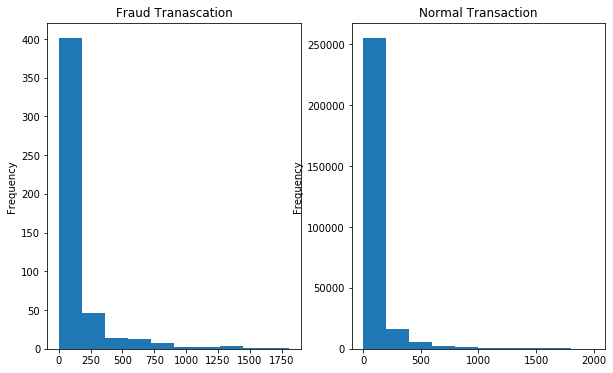

In [5]:
Fraud_transacation = data[data["Class"]==1]
Normal_transacation= data[data["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
Fraud_transacation[Fraud_transacation["Amount"]<= 2000].Amount.plot.hist(title="Fraud Tranascation")
plt.subplot(122)
Normal_transacation[Normal_transacation["Amount"]<=2000].Amount.plot.hist(title="Normal Transaction")

2.3. Первичный визуальный анализ с помощью корреляции. Корреляция показывает насколько зависимы одни параметры от других

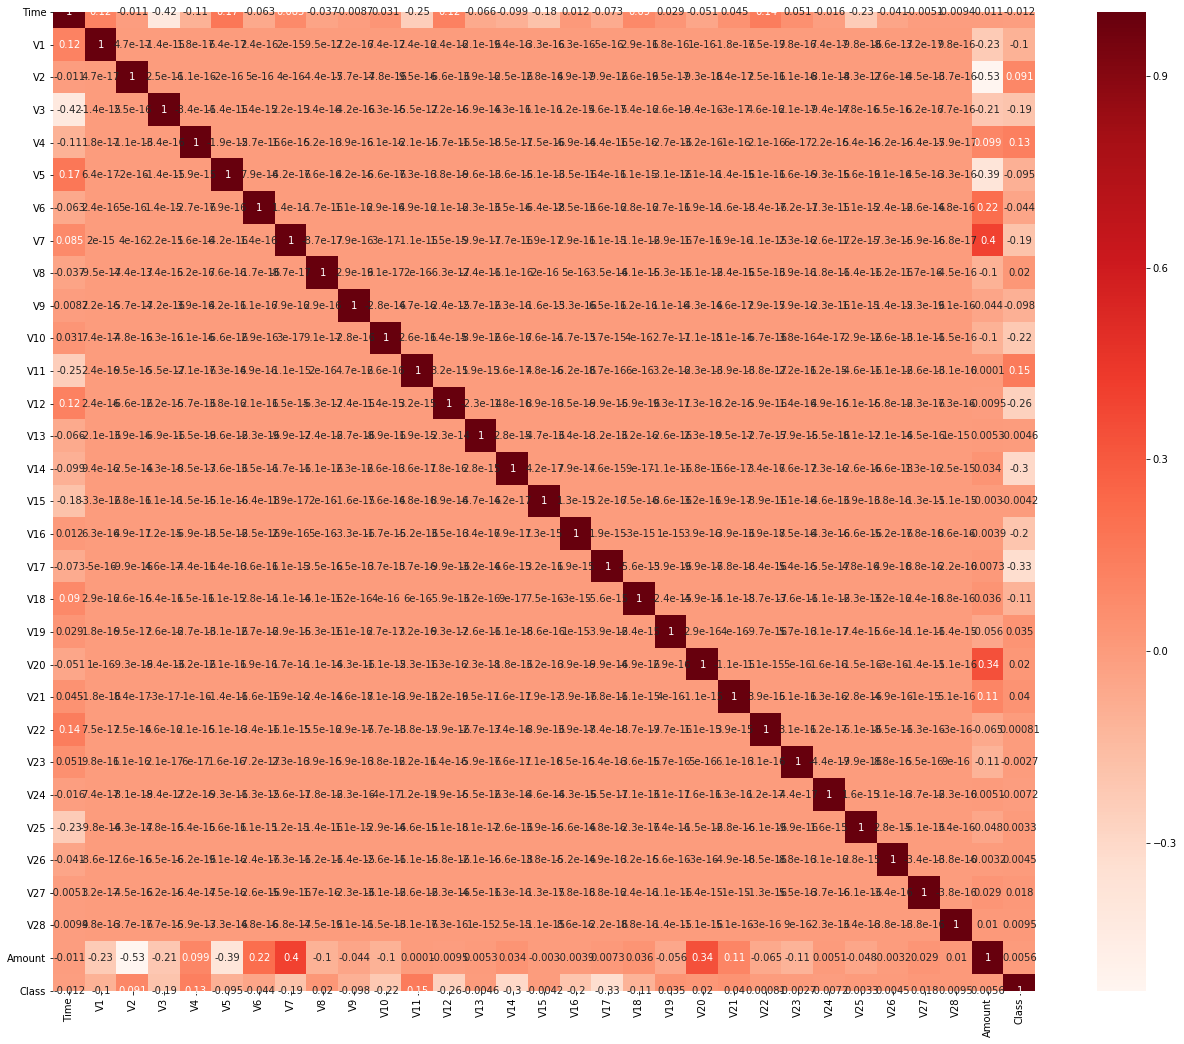

In [6]:
#corelation
plt.figure(figsize=(22,18))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

2.4. Найденные зависимости: (описание на основе корреляции)
Можно заметить, что некоторые квадраты более красные, чем другие. Так мы можем вывести некоторые зависимости.
Amount and V6 = 0.22
Amount and V7 = 0.4
Amount and V20 = 0.34
Amount and V21 = 0.11

V1 and Time = 0.12
V5 and Time = 0.17
V12 and Time = 0.12
V22 and Time = 0.14

Можно выявить, что все основные зависимости строятся на параметрах Amount and Time. 
Но стоит проверить наверняка какие параметры будут больше влиять на данные.

3. Метрики качества:
До ресемплинга давайте вглянем какие параметры будем использовать для определения качества.
Accuracy = TP+TN/Total

Precison = TP/(TP+FP)

Recall = TP/(TP+FN)

Точность (precision) и полнота (recall) являются метриками которые используются при оценке большей части алгоритмов извлечения информации. 

Точность системы в пределах класса – это доля документов действительно принадлежащих данному классу относительно всех документов которые система отнесла к этому классу. Полнота системы – это доля найденных классфикатором документов принадлежащих классу относительно всех документов этого класса в тестовой выборке.

TP = True possitive means no of possitve cases which are predicted possitive

TN = True negative means no of negative cases which are predicted negative

FP = False possitve means no of negative cases which are predicted possitive

FN= False Negative means no of possitive cases which are predicted negative

В нашем случае лучше оценивать по Recall, т.к. кол-во нормальных транзакций намного больше, чем мошеннических.
Также, иногда мошеннические транзакции могут определяться, как нормальные.

Попробуем создать данные с разными размерами, 
научить модели по этим данным и проверить предсказывание модели на оригинальных данных.

In [2]:

#объявим функцию для изменения размера данных
def undersample(normal_indices,fraud_indices,times):#times обозначает нормальные транз = время * мошеннич транз
    Normal_indices_undersample = np.array(np.random.choice(normal_indices,(times*Count_Fraud_transacation),replace=False))
    undersample_data= np.concatenate([fraud_indices,Normal_indices_undersample]) #создаем сбалансированные данные
    undersample_data = data.iloc[undersample_data]
    
    print("Нормальных транзакций :",len(undersample_data[undersample_data["Class"]==0])/len(undersample_data))
    print("Мошеннических транзакций :",len(undersample_data[undersample_data["Class"]==1])/len(undersample_data))
    print("Кол-во записанных измененных данных:",len(undersample_data))
    return(undersample_data)

In [3]:
# Функция создания данных модели
def model(model,features_train,features_test,labels_train,labels_test):
    clf= model #указываем модель, на которой будем обучать данные
    clf.fit(features_train,labels_train.values.ravel()) #вставляем данные в модель
    pred=clf.predict(features_test) #записываем предсказания
    cnf_matrix=confusion_matrix(labels_test,pred) #строим матрицу на основании предсказаний, 
    #чтобы узнать насколько точны предсказания
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(12,6))# Создаем фигуру
    print("TP",cnf_matrix[1,1,]) # кол-во мошен транз предсказанных, как мошеннические
    print("TN",cnf_matrix[0,0]) # кол-во нормальных транз предсказанных, как нормальные
    print("FP",cnf_matrix[0,1]) # кол-во нормальных транзакций предсказанных, как мошеннические
    print("FN",cnf_matrix[1,0]) # кол-во мошен транз предсказанных, как нормальные
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=1)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred))

In [4]:
def data_prepration(x): # функция разделения первоначальных данных на трэйн и тест 
    x_features= x.ix[:,x.columns != "Class"]
    x_labels=x.ix[:,x.columns=="Class"]
    x_features_train,x_features_test,x_labels_train,x_labels_test = train_test_split(x_features,x_labels,test_size=0.3)
    print("length of training data")
    print(len(x_features_train))
    print("length of test data")
    print(len(x_features_test))
    return(x_features_train,x_features_test,x_labels_train,x_labels_test)

In [10]:
# До начала стандартизируем наш Amount столбец
data["Normalized Amount"] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.drop(["Time","Amount"],axis=1,inplace=True)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


undersample данные для 1 итерации

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
------------------------------------------------------------

Классификация модели для 1 итерации

length of training data
688
length of test data
296

the recall for this model is : 0.9020979020979021
TP 129
TN 151
FP 2
FN 14


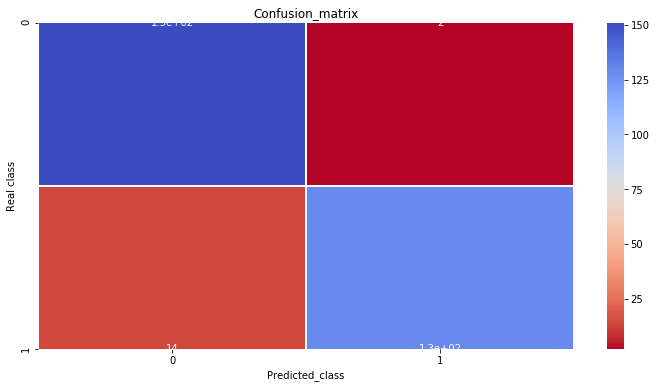


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       153
           1       0.98      0.90      0.94       143

    accuracy                           0.95       296
   macro avg       0.95      0.94      0.95       296
weighted avg       0.95      0.95      0.95       296

________________________________________________________________________________________________________
undersample данные для 2 итерации

Нормальных транзакций : 0.6666666666666666
Мошеннических транзакций : 0.3333333333333333
Кол-во записанных измененных данных: 1476
------------------------------------------------------------

Классификация модели для 2 итерации

length of training data
1033
length of test data
443

the recall for this model is : 0.9366197183098591
TP 133
TN 297
FP 4
FN 9


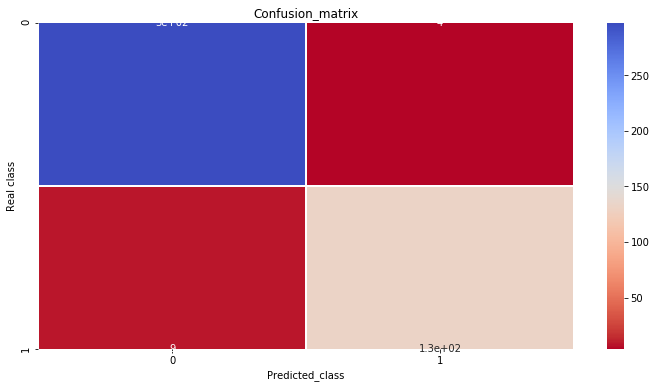


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       301
           1       0.97      0.94      0.95       142

    accuracy                           0.97       443
   macro avg       0.97      0.96      0.97       443
weighted avg       0.97      0.97      0.97       443

________________________________________________________________________________________________________
undersample данные для 3 итерации

Нормальных транзакций : 0.75
Мошеннических транзакций : 0.25
Кол-во записанных измененных данных: 1968
------------------------------------------------------------

Классификация модели для 3 итерации

length of training data
1377
length of test data
591

the recall for this model is : 0.9121621621621622
TP 135
TN 436
FP 7
FN 13


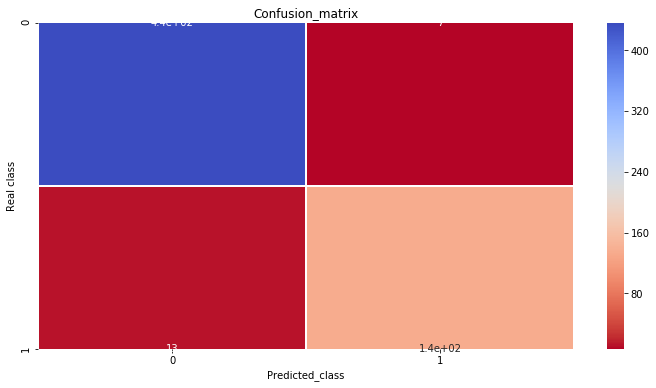


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       443
           1       0.95      0.91      0.93       148

    accuracy                           0.97       591
   macro avg       0.96      0.95      0.95       591
weighted avg       0.97      0.97      0.97       591

________________________________________________________________________________________________________


In [11]:
# посчитаем кол-во нормальных и мошеннических транзакций.
fraud_indices= np.array(data[data["Class"]==1].index)
normal_indices = np.array(data[data["Class"]==0].index)

# Проверим логистическую регрессию на undersample данных
for i in range(1,4):
    print("undersample данные для {} итерации".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("Классификация модели для {} итерации".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf=LogisticRegression()
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")

На всех итерациях можно заметить, что Реколл для нормальных транзакций увеличивается, когда мошеннические уменьшаются. 
Нужно так составить данные, подобрать классификатор, выбрать нужные параметры, отсечь мало влияющие параметры,
чтобы на тестовых данных ошибка была минимальна и модель предсказывала правильно для решения проблемы. 
В нашем случае, чтобы правильно предсказывать мошеннические транзакции и отличать их от обычных.

undersample данные для 1 итерации

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
------------------------------------------------------------

Классификация модели для 1 итерации

length of training data
688
length of test data
296
length of training data
199364
length of test data
85443

the recall for this model is : 0.935251798561151
TP 130
TN 83254
FP 2050
FN 9


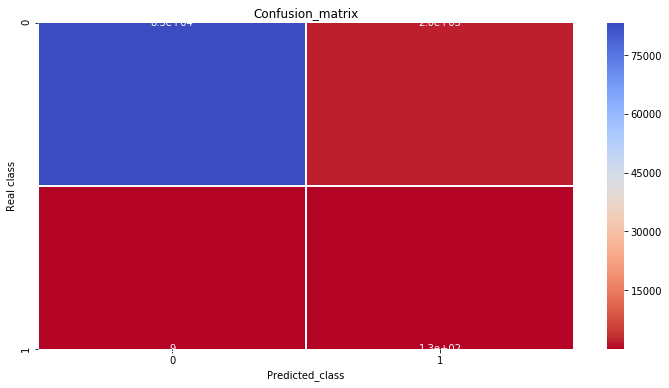


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85304
           1       0.06      0.94      0.11       139

    accuracy                           0.98     85443
   macro avg       0.53      0.96      0.55     85443
weighted avg       1.00      0.98      0.99     85443

_________________________________________________________________________________________
undersample данные для 2 итерации

Нормальных транзакций : 0.6666666666666666
Мошеннических транзакций : 0.3333333333333333
Кол-во записанных измененных данных: 1476
------------------------------------------------------------

Классификация модели для 2 итерации

length of training data
1033
length of test data
443
length of training data
199364
length of test data
85443

the recall for this model is : 0.8961038961038961
TP 138
TN 84073
FP 1216
FN 16


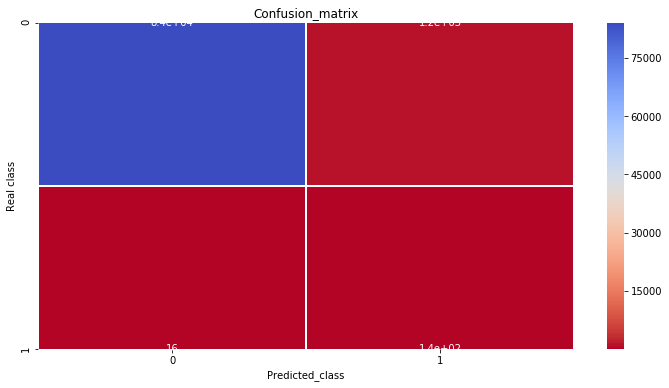


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85289
           1       0.10      0.90      0.18       154

    accuracy                           0.99     85443
   macro avg       0.55      0.94      0.59     85443
weighted avg       1.00      0.99      0.99     85443

_________________________________________________________________________________________
undersample данные для 3 итерации

Нормальных транзакций : 0.75
Мошеннических транзакций : 0.25
Кол-во записанных измененных данных: 1968
------------------------------------------------------------

Классификация модели для 3 итерации

length of training data
1377
length of test data
591
length of training data
199364
length of test data
85443

the recall for this model is : 0.8819444444444444
TP 127
TN 84164
FP 1135
FN 17


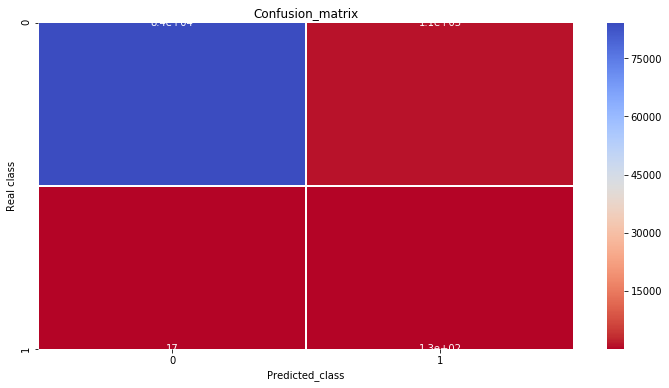


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85299
           1       0.10      0.88      0.18       144

    accuracy                           0.99     85443
   macro avg       0.55      0.93      0.59     85443
weighted avg       1.00      0.99      0.99     85443

_________________________________________________________________________________________


In [13]:
#Попробуем тренировать модель используя андерсэмпл данные и тестовые данные для полного набора данных
for i in range(1,4):
    print("undersample данные для {} итерации".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("Классификация модели для {} итерации".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    #часть всех данных
    print()
    clf=LogisticRegression()
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    # тренируем на андерсемплинге, тестим на полных данных
    print("_________________________________________________________________________________________")

Реколл на полных данных также хорошо работает, но у Пресижн очень маленькое значение
Маленький пресижн значит, что мы предсказали неверно. 
Среди этих транзакций мы предсказали некоторые нормальные транзакции, как мошеннические, что неправильно

Попробуем использовать SVM и Random Forest на undersample data.

the undersample data for 1 proportion

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296

the recall for this model is : 0.9215686274509803
TP 141
TN 139
FP 4
FN 12


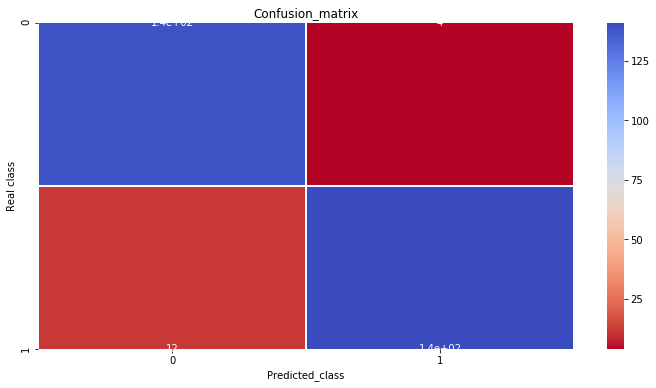


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       143
           1       0.97      0.92      0.95       153

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296

________________________________________________________________________________________________________
the undersample data for 2 proportion

Нормальных транзакций : 0.6666666666666666
Мошеннических транзакций : 0.3333333333333333
Кол-во записанных измененных данных: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443

the recall for this model is : 0.9051094890510949
TP 124
TN 297
FP 9
FN 13


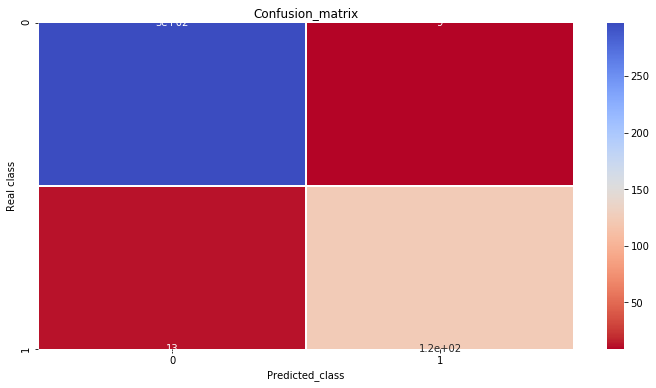


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       306
           1       0.93      0.91      0.92       137

    accuracy                           0.95       443
   macro avg       0.95      0.94      0.94       443
weighted avg       0.95      0.95      0.95       443

________________________________________________________________________________________________________
the undersample data for 3 proportion

Нормальных транзакций : 0.75
Мошеннических транзакций : 0.25
Кол-во записанных измененных данных: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591

the recall for this model is : 0.8896551724137931
TP 129
TN 436
FP 10
FN 16


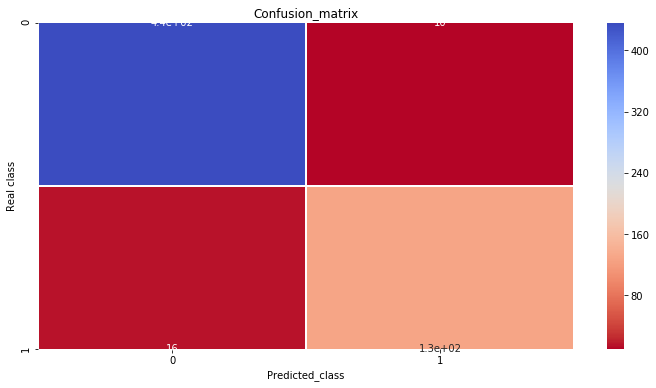


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       446
           1       0.93      0.89      0.91       145

    accuracy                           0.96       591
   macro avg       0.95      0.93      0.94       591
weighted avg       0.96      0.96      0.96       591

________________________________________________________________________________________________________


In [16]:
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf= SVC()# меняем классификатор с логистической регрессии на SVC
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")

Здесь пресижн и реколл показывают результаты лучше, чем у логистической регрессии. Попробуем на полных данных.

the undersample data for 1 proportion

------------------------------------------------------------

the model classification for 1 proportion

length of training data
199364
length of test data
85443
length of training data
199364
length of test data
85443

the recall for this model is : 0.78125
TP 125
TN 85281
FP 2
FN 35


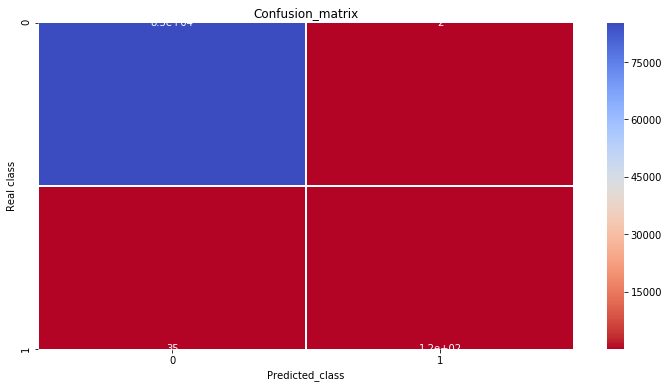


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85283
           1       0.98      0.78      0.87       160

    accuracy                           1.00     85443
   macro avg       0.99      0.89      0.94     85443
weighted avg       1.00      1.00      1.00     85443

_________________________________________________________________________________________
the undersample data for 2 proportion

------------------------------------------------------------

the model classification for 2 proportion

length of training data
199364
length of test data
85443
length of training data
199364
length of test data
85443

the recall for this model is : 0.7293233082706767
TP 97
TN 85307
FP 3
FN 36


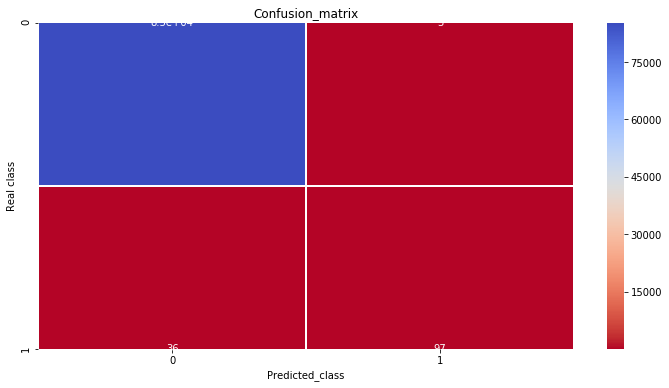


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85310
           1       0.97      0.73      0.83       133

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.92     85443
weighted avg       1.00      1.00      1.00     85443

_________________________________________________________________________________________
the undersample data for 3 proportion

------------------------------------------------------------

the model classification for 3 proportion

length of training data
199364
length of test data
85443
length of training data
199364
length of test data
85443

the recall for this model is : 0.7972972972972973
TP 118
TN 85290
FP 5
FN 30


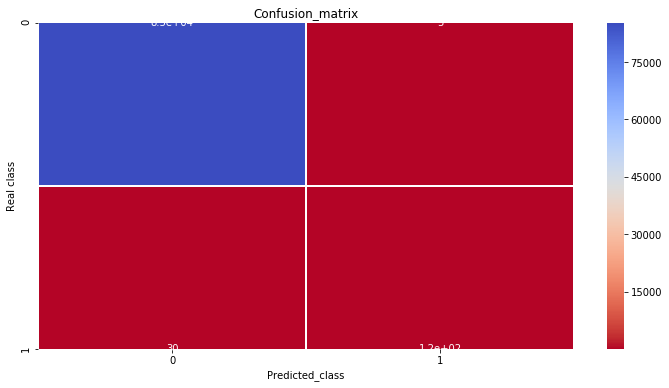


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.96      0.80      0.87       148

    accuracy                           1.00     85443
   macro avg       0.98      0.90      0.94     85443
weighted avg       1.00      1.00      1.00     85443

_________________________________________________________________________________________


In [19]:
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = data
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
#     Делим данные на андерсемпл наборе
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
#     Делим данные у полных данных
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    print()
    clf=SVC()
#     загоняем все в модель и смотрим результат предсказывания на полных данных
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    print("_________________________________________________________________________________________")

Пресижн увеличился, но рекол сильно уменьшился,что значит,  что эта модель работает не лучше логистической регрессии

Попробуем Рандомный лес на андерсемпл данных

the undersample data for 1 proportion

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296

the recall for this model is : 0.9038461538461539
TP 141
TN 137
FP 3
FN 15


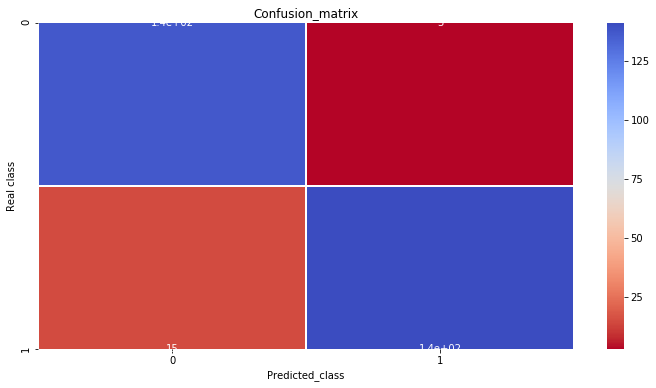


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       140
           1       0.98      0.90      0.94       156

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296

________________________________________________________________________________________________________
the undersample data for 2 proportion

Нормальных транзакций : 0.6666666666666666
Мошеннических транзакций : 0.3333333333333333
Кол-во записанных измененных данных: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443

the recall for this model is : 0.9090909090909091
TP 130
TN 299
FP 1
FN 13


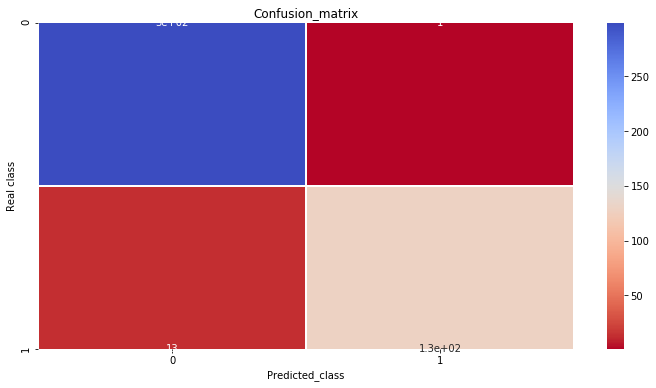


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       300
           1       0.99      0.91      0.95       143

    accuracy                           0.97       443
   macro avg       0.98      0.95      0.96       443
weighted avg       0.97      0.97      0.97       443

________________________________________________________________________________________________________
the undersample data for 3 proportion

Нормальных транзакций : 0.75
Мошеннических транзакций : 0.25
Кол-во записанных измененных данных: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591

the recall for this model is : 0.8535031847133758
TP 134
TN 430
FP 4
FN 23


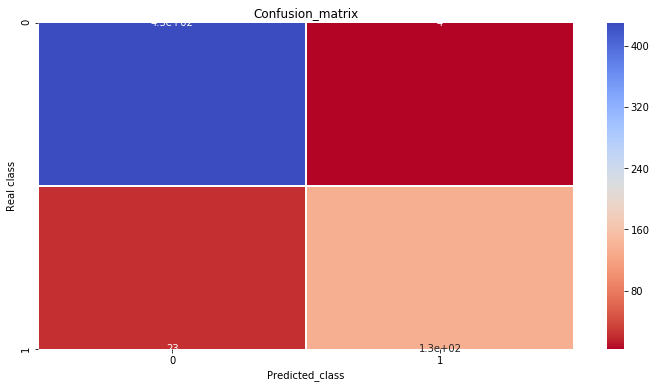


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       434
           1       0.97      0.85      0.91       157

    accuracy                           0.95       591
   macro avg       0.96      0.92      0.94       591
weighted avg       0.96      0.95      0.95       591

________________________________________________________________________________________________________


In [20]:
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
    print()
    clf= RandomForestClassifier(n_estimators=100)
    model(clf,undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test)
    print("________________________________________________________________________________________________________")

the undersample data for 1 proportion

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
------------------------------------------------------------

the model classification for 1 proportion

length of training data
688
length of test data
296
length of training data
199364
length of test data
85443

the recall for this model is : 0.9743589743589743
TP 152
TN 83749
FP 1538
FN 4


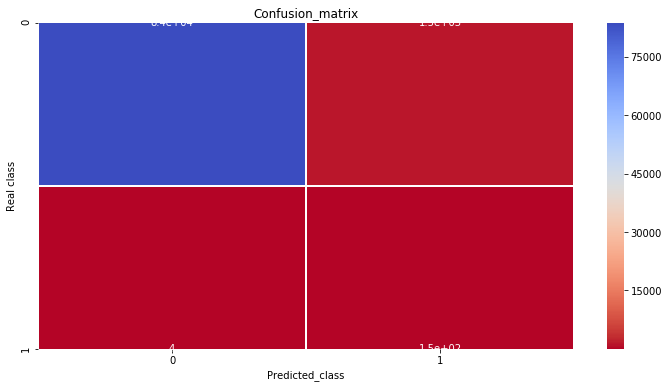


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85287
           1       0.09      0.97      0.16       156

    accuracy                           0.98     85443
   macro avg       0.54      0.98      0.58     85443
weighted avg       1.00      0.98      0.99     85443

_________________________________________________________________________________________
the undersample data for 2 proportion

Нормальных транзакций : 0.6666666666666666
Мошеннических транзакций : 0.3333333333333333
Кол-во записанных измененных данных: 1476
------------------------------------------------------------

the model classification for 2 proportion

length of training data
1033
length of test data
443
length of training data
199364
length of test data
85443

the recall for this model is : 0.951048951048951
TP 136
TN 84573
FP 727
FN 7


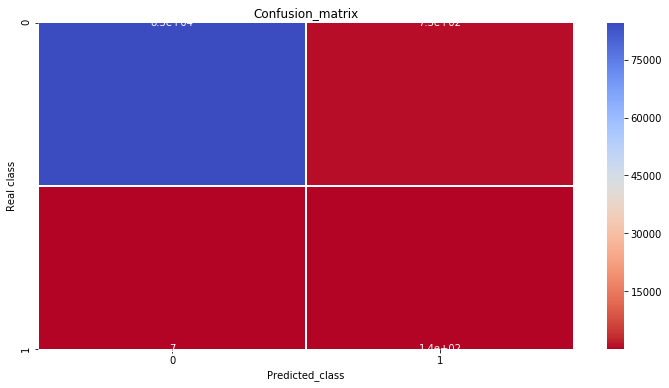


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85300
           1       0.16      0.95      0.27       143

    accuracy                           0.99     85443
   macro avg       0.58      0.97      0.63     85443
weighted avg       1.00      0.99      0.99     85443

_________________________________________________________________________________________
the undersample data for 3 proportion

Нормальных транзакций : 0.75
Мошеннических транзакций : 0.25
Кол-во записанных измененных данных: 1968
------------------------------------------------------------

the model classification for 3 proportion

length of training data
1377
length of test data
591
length of training data
199364
length of test data
85443

the recall for this model is : 0.9397590361445783
TP 156
TN 85121
FP 156
FN 10


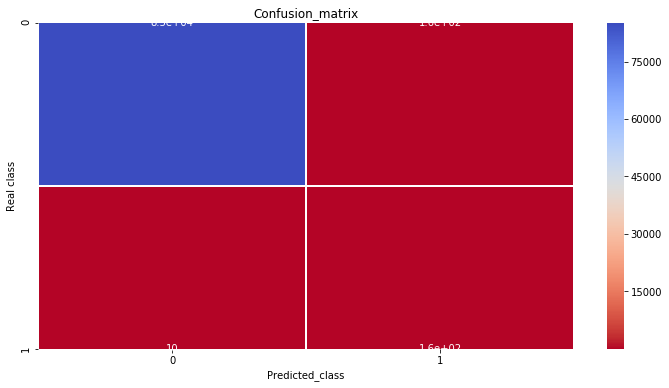


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85277
           1       0.50      0.94      0.65       166

    accuracy                           1.00     85443
   macro avg       0.75      0.97      0.83     85443
weighted avg       1.00      1.00      1.00     85443

_________________________________________________________________________________________


In [21]:
# Пробуем на фул данных
for i in range(1,4):
    print("the undersample data for {} proportion".format(i))
    print()
    Undersample_data = undersample(normal_indices,fraud_indices,i)
    print("------------------------------------------------------------")
    print()
    print("the model classification for {} proportion".format(i))
    print()
    #     Делим данные на андерсемпл наборе
    undersample_features_train,undersample_features_test,undersample_labels_train,undersample_labels_test=data_prepration(Undersample_data)
#     Делим данные у полных данных
    data_features_train,data_features_test,data_labels_train,data_labels_test=data_prepration(data) 
    print()
    clf=RandomForestClassifier(n_estimators=100)
    model(clf,undersample_features_train,data_features_test,undersample_labels_train,data_labels_test)
    # here training for the undersample data but tatsing for whole data
    print("_________________________________________________________________________________________")

Здесь пресижн явно ниже, чем обычно у других. Рекол примерно такой же. 
Значит рандомный лес не справляется с этой задачей лучше других! Попробуем выбрать только более значимые параметры для анализа

In [22]:
featimp = pd.Series(clf.feature_importances_,index=data_features_train.columns).sort_values(ascending=False)
print(featimp) # важные параметры

V14                  0.199960
V10                  0.132120
V17                  0.130228
V12                  0.087108
V4                   0.060492
V11                  0.055222
V7                   0.048958
V16                  0.045651
V3                   0.044988
V21                  0.024072
V18                  0.024041
V9                   0.017330
V2                   0.016245
V19                  0.011148
V5                   0.010276
V27                  0.009188
V15                  0.008667
V20                  0.007991
V23                  0.007918
V22                  0.006873
Normalized Amount    0.006803
V13                  0.006470
V8                   0.006330
V6                   0.006194
V1                   0.005808
V28                  0.005699
V24                  0.004991
V25                  0.004737
V26                  0.004490
dtype: float64


In [23]:
data1=data[["V10","V14","V12","V4","V17","Class"]]
data1.head()

,V10,V14,V12,V4,V17,Class
0,0.090794,-0.311169,-0.617801,1.378155,0.207971,0
1,-0.166974,-0.143772,1.065235,0.448154,-0.114805,0
2,0.207643,-0.165946,0.066084,0.379780,1.109969,0
3,-0.054952,-0.287924,0.178228,-0.863291,-0.684093,0
4,0.753074,-1.119670,0.538196,0.403034,-0.237033,0


In [24]:
'''
Попробуем сделать андерсемплинг для новых данных
'''
Normal_indices_undersample = np.array(np.random.choice(normal_indices,(1*Count_Fraud_transacation),replace=False))
undersample_data1 = np.concatenate([fraud_indices,Normal_indices_undersample]) #создаем сбалансированные данные
undersample_data1 = data1.iloc[undersample_data1]    
print("Нормальных транзакций :",len(undersample_data1[undersample_data1["Class"]==0])/len(undersample_data1))
print("Мошеннических транзакций :",len(undersample_data1[undersample_data1["Class"]==1])/len(undersample_data1))
print("Кол-во записанных измененных данных:",len(undersample_data1))
    
Undersample_data1_features_train,Undersample_data1_features_test,Undersample_data1_labels_train,Undersample_data1_labels_test = data_prepration(undersample_data1)

Нормальных транзакций : 0.5
Мошеннических транзакций : 0.5
Кол-во записанных измененных данных: 984
length of training data
688
length of test data
296


the recall for this model is : 0.900709219858156
TP 127
TN 151
FP 4
FN 14


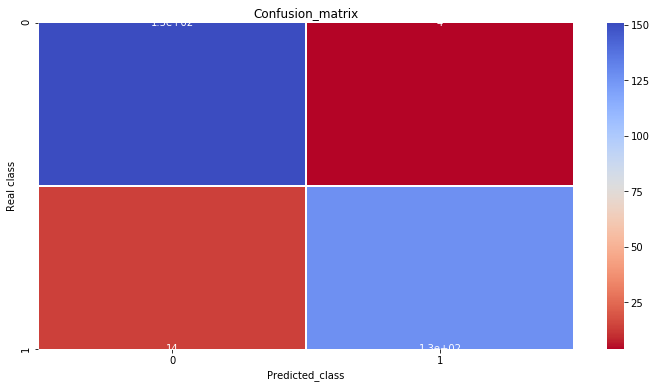


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       155
           1       0.97      0.90      0.93       141

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [25]:
clf= RandomForestClassifier(n_estimators=100)
model(clf,Undersample_data1_features_train,Undersample_data1_features_test,Undersample_data1_labels_train,Undersample_data1_labels_test)

Как можно заметить, пресижн вырос по сравнению с другими примерами, когда мы начали использовать только важные параметры
Попробуем теперь использовать оверсемпл данные для обучения модели. Сделаем оверсемпл для тренировочных данных.

In [26]:
data=pd.read_csv("creditcard.csv")

print("length of training data",len(data))
print("length of normal data",len(data[data["Class"]==0]))
print("length of fraud  data",len(data[data["Class"]==1]))
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(data)
data_train_X.columns
data_train_y.columns

length of training data 284807
length of normal data 284315
length of fraud  data 492
length of training data
199364
length of test data
85443


Index(['Class'], dtype='object')

In [27]:
# Тренировочные данные
data_train_X["Class"]= data_train_y["Class"]
data_train = data_train_X.copy()
print("length of training data",len(data_train))
# Создадим набор нормальных транзакций 
normal_data = data_train[data_train["Class"]==0]
print("length of normal data",len(normal_data))
fraud_data = data_train[data_train["Class"]==1]
print("length of fraud data",len(fraud_data))

# Оверсемплим данные
# Что значит мы дублируем данные мошеннических транзакций
for i in range (365):
    normal_data= normal_data.append(fraud_data)
os_data = normal_data.copy() 
print("length of oversampled data is ",len(os_data))
print("Number of normal transcation in oversampled data",len(os_data[os_data["Class"]==0]))
print("No.of fraud transcation",len(os_data[os_data["Class"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data[os_data["Class"]==0])/len(os_data))
print("Proportion of fraud data in oversampled data is ",len(os_data[os_data["Class"]==1])/len(os_data))


length of training data 199364
length of normal data 199008
length of fraud data 356
length of oversampled data is  328948
Number of normal transcation in oversampled data 199008
No.of fraud transcation 129940
Proportion of Normal data in oversampled data is  0.6049831584323359
Proportion of fraud data in oversampled data is  0.3950168415676642


In [28]:
# До того, как будет использовать модели стандартизируем наши данные по параметру Amount
os_data["Normalized Amount"] = StandardScaler().fit_transform(os_data['Amount'].values.reshape(-1, 1))
os_data.drop(["Time","Amount"],axis=1,inplace=True)
os_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized Amount
33736,1.065917,0.249522,1.030426,2.358078,-0.358998,0.470426,-0.476696,0.340834,-0.548662,0.827692,...,0.210762,0.529282,-0.032664,0.000185,0.293946,0.112333,0.017210,0.014911,0,-0.360911
93945,-0.431572,0.985585,1.446022,-0.225699,0.143806,-0.383552,0.592316,0.104484,-0.625337,-0.141253,...,-0.198850,-0.547206,-0.075507,-0.022801,-0.181403,0.074573,0.260828,0.107314,0,-0.392110
100661,1.290837,-1.466300,0.863674,-1.226840,-2.089233,-0.702420,-1.253335,-0.084426,-1.438807,1.369760,...,-0.143022,-0.277620,0.025382,0.347167,0.107304,-0.270818,0.036940,0.049302,0,0.041614
105095,1.070888,0.227015,0.919366,1.331427,-0.554464,-0.539833,-0.033100,-0.070014,-0.052932,-0.056987,...,0.014302,0.064237,0.089428,0.603912,0.288573,-0.488236,0.051453,0.041074,0,-0.261554
11167,1.186084,-0.289153,1.021152,-0.566535,-0.922776,-0.294245,-0.700767,-0.001424,3.038933,-1.511691,...,-0.123897,0.170513,-0.008875,0.048890,0.414190,-0.698024,0.084044,0.028246,0,-0.356208


length of training data
230263
length of test data
98685
the recall for this model is : 1.0
TP 39066
TN 59614
FP 5
FN 0


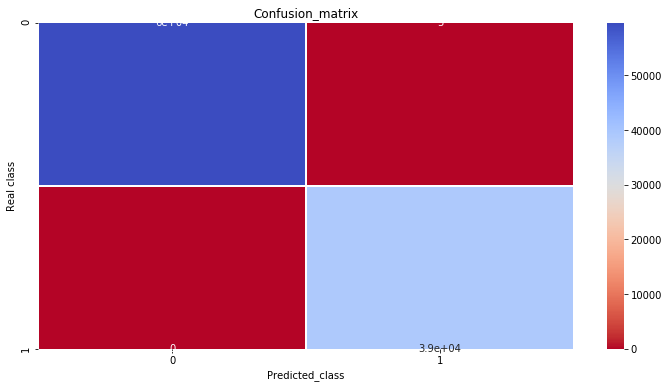


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59619
           1       1.00      1.00      1.00     39066

    accuracy                           1.00     98685
   macro avg       1.00      1.00      1.00     98685
weighted avg       1.00      1.00      1.00     98685



In [29]:
# Используем наши оверсемпл данные для предсказания модели
# разобъем оверсемпл данные на трэйн и тест
os_train_X,os_test_X,os_train_y,os_test_y=data_prepration(os_data)
clf= RandomForestClassifier(n_estimators=100)
model(clf,os_train_X,os_test_X,os_train_y,os_test_y)

In [30]:
'''
Отличный результат! Попробуем на тестовых данных! Возможен оверфитинг - слишком точная подгонка параметров модели, 
которая не работает правильно на реальных данных
'''
# Делаем то же самое для тестовых данных
os_data_X = os_data.ix[:,os_data.columns != "Class"]
os_data_y = os_data.ix[:,os_data.columns == "Class"]
#стандартизируем Эмаунт и сбросим время
data_test_X["Normalized Amount"] = StandardScaler().fit_transform(data_test_X['Amount'].values.reshape(-1, 1))
data_test_X.drop(["Time","Amount"],axis=1,inplace=True)
data_test_X.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Normalized Amount
279556,2.067625,-0.124687,-1.111147,0.411437,-0.206450,-1.203987,0.111209,-0.271403,0.704283,0.104542,...,-0.291296,-0.305892,-0.795636,0.345964,-0.052948,-0.325241,0.203355,-0.077483,-0.062966,-0.335312
13888,1.079863,0.356225,0.234434,1.341948,0.085699,-0.407280,0.244817,-0.071072,0.822541,-0.176030,...,-0.201682,-0.375280,-0.990656,0.120691,0.098374,0.302950,-0.687043,-0.031341,0.007299,-0.170424
46779,-0.001660,1.154354,0.190129,1.076060,0.692658,-0.287966,1.117474,-0.151796,-0.794395,0.208434,...,0.196432,0.182461,0.768233,0.050291,-0.250465,-0.805050,-0.306608,0.509720,0.300866,-0.193373
85667,-0.305513,1.177800,1.085639,-0.071404,0.364781,-0.652305,0.767869,-0.090495,-0.494911,-0.538735,...,0.192497,-0.287732,-0.714711,-0.087895,-0.179835,-0.057844,0.102128,0.250202,0.094898,-0.319631
129519,-1.543022,0.843709,0.547720,1.133213,-1.212669,-0.366367,0.388428,0.499008,-2.771751,0.301122,...,-0.471466,-0.140028,-0.096855,-0.160382,0.642742,0.339004,-0.008074,-0.113169,-0.202610,0.311506


the recall for this model is : 0.7205882352941176
TP 98
TN 85302
FP 5
FN 38


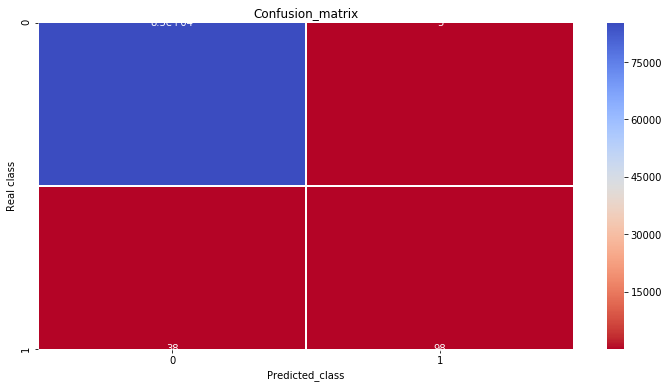


----------Classification Report------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.72      0.82       136

    accuracy                           1.00     85443
   macro avg       0.98      0.86      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [31]:
# Протестируем модель на тестовых данных
clf= RandomForestClassifier(n_estimators=100)
model(clf,os_data_X,data_test_X,os_data_y,data_test_y)

Как и говорилось! Произошло переобучение данных и модель не смогла правильно предсказать на тестовых данных. 
Из этого следует, что оверсемплинг не подходит для данной задачи, хоть рандомное дерево и справлялось лучше других.

Нужно поработать с кросс валидацией и гиперпараметрами!
Было видно и понятно, что на андерсемпл данных лучше всего справляется рандомное дерево.
Отобразим это на рог кривой относительно других способов.

Обработаем данные снова! Проверим какой алгоритм работает лучше на сгенерированных данных. Для этого нужно:
1. Сгенерировать данные
2. Обработать все параметры
3. Указать таргет, данные на которых обучается модель и на которых будет тестироваться
4. Загнать данные в модель
5. Проверить предикты
6. Отобразить на рок кривой

In [5]:
data2=pd.read_csv("creditcard.csv")

print("length of training data",len(data))
print("length of normal data",len(data[data["Class"]==0]))
print("length of fraud  data",len(data[data["Class"]==1]))
data_train_X,data_test_X,data_train_y,data_test_y=data_prepration(data2)

# Тренировочные данные
data_train_X["Class"]= data_train_y["Class"]
data_train = data_train_X.copy()
print("length of training data",len(data_train))
# Создадим набор нормальных транзакций 
normal_data = data_train[data_train["Class"]==0]
print("length of normal data",len(normal_data))
fraud_data = data_train[data_train["Class"]==1]
print("length of fraud data",len(fraud_data))

# Оверсемплим данные
# Что значит мы дублируем данные мошеннических транзакций
for i in range (365):
    normal_data= normal_data.append(fraud_data)
os_data = normal_data.copy() 
print("length of oversampled data is ",len(os_data))
print("Number of normal transcation in oversampled data",len(os_data[os_data["Class"]==0]))
print("No.of fraud transcation",len(os_data[os_data["Class"]==1]))
print("Proportion of Normal data in oversampled data is ",len(os_data[os_data["Class"]==0])/len(os_data))
print("Proportion of fraud data in oversampled data is ",len(os_data[os_data["Class"]==1])/len(os_data))

# До того, как будет использовать модели стандартизируем наши данные по параметру Amount
os_data["Normalized Amount"] = StandardScaler().fit_transform(os_data['Amount'].values.reshape(-1, 1))
os_data.drop(["Time","Amount"],axis=1,inplace=True)
os_data.head()

# Делаем то же самое для тестовых данных
os_data_X = os_data.ix[:,os_data.columns != "Class"]
os_data_y = os_data.ix[:,os_data.columns == "Class"]
#стандартизируем Эмаунт и сбросим время
data_test_X["Normalized Amount"] = StandardScaler().fit_transform(data_test_X['Amount'].values.reshape(-1, 1))
data_test_X.drop(["Time","Amount"],axis=1,inplace=True)
data_test_X.head()




length of training data 284807
length of normal data 284315
length of fraud  data 492
length of training data
199364
length of test data
85443
length of training data 199364
length of normal data 199009
length of fraud data 355
length of oversampled data is  328584
Number of normal transcation in oversampled data 199009
No.of fraud transcation 129575
Proportion of Normal data in oversampled data is  0.6056563922771651
Proportion of fraud data in oversampled data is  0.39434360772283494


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Normalized Amount
1172,-0.820178,1.225605,1.517290,-0.007492,0.310123,-0.936490,1.026234,-0.163058,-0.500997,-0.424367,...,0.015005,0.032831,0.136686,-0.347711,0.390412,0.849821,-0.405567,0.074595,0.040960,-0.313362
17439,1.548510,-1.058162,0.384006,-1.718831,-1.114312,0.205602,-1.310541,0.016813,-1.945282,1.567125,...,-0.209258,-0.075670,0.234233,-0.166442,-0.815275,0.505906,-0.051424,0.054955,0.006748,-0.329239
74520,-1.352460,-0.592393,2.339080,-0.753394,0.109336,-0.215174,-0.030164,0.268215,0.526515,-1.289442,...,0.287627,-0.009095,-0.154742,0.221603,0.153912,-0.134971,0.805446,-0.014338,0.109635,0.021115
144898,-0.882897,0.231040,-0.438285,1.035081,1.263185,-1.066100,1.486364,-0.343630,-1.131769,0.242024,...,-0.148257,0.336799,0.940709,-0.241815,0.025693,-0.015026,-0.340238,0.108934,0.190964,0.227885
221486,-5.042680,3.571119,-2.049769,-0.678787,-3.046975,-0.734559,-2.624992,3.681058,0.112743,-0.112563,...,0.085011,0.392866,0.723022,0.034347,0.123643,0.391566,0.653678,0.077960,0.076914,-0.329724


In [10]:
# Задаем какими моделями мы будем пользоваться
rf_lr = LogisticRegression()
rf_enc = OneHotEncoder(categories='auto')
rf = RandomForestClassifier(n_estimators=100)
dt = DecisionTreeClassifier(max_depth=4, random_state=0)
lr =LogisticRegression()

In [11]:
#указываем модель, на которой будем обучать данные
rf.fit(os_data_X,os_data_y) #вставляем данные в модель
rf_enc.fit(rf.apply(os_data_X))

OneHotEncoder(categorical_features=None, categories='auto', drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [12]:
# Вставляем данные в логистическую регрессию с рандомным лесом и в дерево решений.
rf_lr.fit(rf_enc.transform(rf.apply(os_data_X)), os_data_y)
dt.fit(os_data_X,os_data_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

Вставим данные в логистическую регрессию.

In [13]:

lr.fit(os_data_X,os_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:

# The random forest model by itself
y_pred_rf = rf.predict_proba(data_test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(data_test_y, y_pred_rf)

In [15]:

#CURVE FOR LOGISTIC REG + RF
y_pred_rf_lm = rf_lr.predict_proba(rf_enc.transform(rf.apply(data_test_X)))[:, 1] #create predictions
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(data_test_y, y_pred_rf_lm) #create curve

In [16]:
#CURVE FOR LOGISTIC REG
y_pred_lm = lr.predict_proba(data_test_X)[:, 1] #create predictions
fpr_lm, tpr_lm, _ = roc_curve(data_test_y, y_pred_rf_lm) #create curve

In [17]:

# The decision tree model by itself
y_pred_dt = dt.predict_proba(data_test_X)[:, 1]
fpr_dt, tpr_dt, _ = roc_curve(data_test_y, y_pred_dt)

После обучения моделей на сгенерированных данных и предсказывания на реальных данных получаем графическое отображение какая модель отрабатывает лучше.

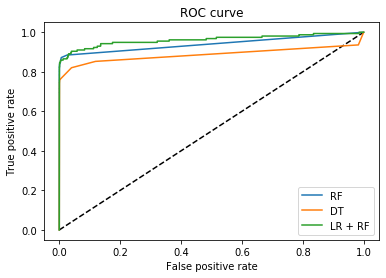

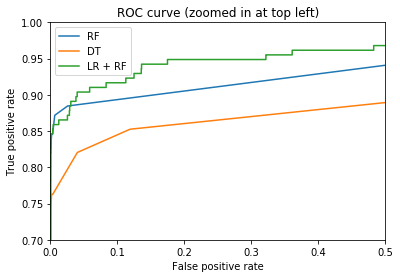

In [20]:

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='LR + RF')
plt.plot(fpr_lm, tpr_lm, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='LR + RF')
plt.plot(fpr_lm, tpr_lm, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [6]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin 
 
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, os_data_X, os_data_y, cv=3).mean()
    print(current_score, params)
    return -current_score

simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_depth':  hp.choice('max_depth', np.arange(1, 14, dtype=int)),
}
 
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.9999086990620624                                                                                                     
{'eta': 0.2, 'max_depth': 8, 'n_estimators': 379}                                                                      
0.9999026123662098                                                                                                     
{'eta': 0.325, 'max_depth': 11, 'n_estimators': 524}                                                                   
0.9999086990620624                                                                                                     
{'eta': 0.35000000000000003, 'max_depth': 11, 'n_estimators': 851}                                                     
0.9998813088890461                                                                                                     
{'eta': 0.275, 'max_depth': 13, 'n_estimators': 165}                                                                   
0.9998995690043905                      

Гиперпараметр - параметр, значение которого настраивается до процесса обучения.

Оптимизация гиперпараметров — задача машинного обучения по выбору набора оптимальных гиперпараметров для обучающего алгоритма.

Одни и те же виды моделей машинного обучения могут требовать различные предположения, веса или скорости обучения для различных видов данных. Эти параметры называются гиперпараметрами и их следует настраивать так, чтобы модель могла оптимально решить задачу обучения. Для этого находится кортеж гиперпараметров, который даёт оптимальную модель, оптимизирующую заданную функцию потерь на заданных независимых данных. Целевая функция берёт кортеж гиперпараметров и возвращает связанные с ними потери. Часто используется перекрёстная проверка для оценки этой обобщающей способности.

Функция потерь — функция, которая в теории статистических решений характеризует потери при неправильном принятии решений на основе наблюдаемых данных. Если решается задача оценки параметра сигнала на фоне помех, то функция потерь является мерой расхождения между истинным значением оцениваемого параметра и оценкой параметра.

Таким образом, для нахождения гиперпареметров используется:
Кросс-валидация и xgboost. Какие параметры мы находим для примера?
1. eta (скорость обучения)
2. max_depth (максимальная глубина дерева), 
3. n_estimators (это число бустеров, которые вы тренируете) чувствительно к гиперпараметрам, которые вы пытаетесь настроить.

Вывод:
    Для разных задач и разного типа данных требуются разные подходы для получения результата.
    Так на своем опыте мы убедились, 
    что не всякий алгоритм получения модели эффективен на андерсемпл и оверсемпл данных.
Например:
    Чтобы получить более менее равномерные данные, обрезаем их.
    Получаем, что:
        1. Логистическая регрессия на тестовых данных дает маленький пресижн, 
        т.е. мы нормальные транзакции предсказываем, как мошеннические.
        2. С помощью SVC поднимается пресижн, но опускается реколл. Значит наш классификатор,
        т.е СВЦ неправильно предсказывает мошеннические транзакции и выдает их за нормальные.
        Но если нас устраивает предсказание с 70% точностью, то окей, но такое маловероятно.
        3. Рандомный лес, как и логистическая регрессия, неправильно предоставляет пресижн.
        Если выбрать влияющие параметры для рандомного леса, то точность пресижена повышается
        и с этой моделью уже можно работать.
    Используем теперь оверсемпл данные:
        На оверсемпл данных случается оверфиттинг данных, т.е. переобучение модели,
        которое приводит к снижению точности при проверке на тестовых данных. Также примерно +-70%
    При отображении на рок-кривой можно заметить, что рандомный лес
    и логистическая регрессия + рандомный лес покрывают большую площадь под графиком,
    следовательно лучше справляются с предиктами.
    
    При настройке кросс-валидации и гиперпараметров можно увидеть какие значения гиперпараметров нужно использовать для получения лучших результатов при обучении.
    
    Общий вывод: 
        Лучшее предсказание мошеннических транзакций получается у рандомного леса при андерсемпл данных и выборе наиболее влияющих параметров.